In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import datetime

In [4]:
entity = "evangeorgerex"
project_name = "fwal"
# sweep_id = "xd36y8wm"

# # Fetch the sweep
# api = wandb.Api()
# sweep = api.sweep(f"{entity}/{project_name}/{sweep_id}")


In [5]:
# runpath = "evangeorgerex/fwal/c4rpo9nd" # mnist run
# runpath = "evangeorgerex/fwal/8s5bm3rj" # good mice protein run
# runpath = "evangeorgerex/fwal/diiym9cy" # coil20
# runpath = "evangeorgerex/fwal/o56v87o7" # isolet
# runpath = "evangeorgerex/fwal/h3y2auch" # usps
# runpath = "evangeorgerex/fwal/zza4vp2w"
runpath = "evangeorgerex/fwal/m1l5bzbb" # only reconstruct masked madelon
# runpath = "evangeorgerex/fwal/aur50m7o" # only reconstruct masked mice protein

api = wandb.Api()
run = api.run(runpath)
dataset = run.config["dataset"]

In [21]:

entity = "evangeorgerex"
project = "fwal"

sweep_ids = [
    # "zkvbu18r", # lasso baseline 
    # "9tjs7cai", # fwal as mlp baseline
    # "22eckaxx", # rf baseline
    # "nmsvf0u4", # fwal new datasets
    # "gty91unf", # rf baseline
    # "efjov5qc", # lasso baseline
    # "zkvbu18r", # lasso baseline more
    # "5kxy8gl8", # fwal as mlp baseline
    # "t1z9hleb", # fwal tti 
    # "3ubxo03v", # finish fwal tti
    # "t8i7yh69", # fwal gisette
    # "cwhd81fy", # fwal MNIST (states are failed despite being finished for some reason)
    "z9b6sox8", # fwal only reconstruct masked
    "xi4jr64q", # fwals only reconstruct masked GPU
    # "aie2q1ph", # cae
    # "uunpksug", # cae
    # "u0xyvsw9", # xgboost
    "ycv2gbna", # fwal only reconstruct masked mice protein more patience
]

In [27]:
hist_dict = {}
mask_dict = {}
for sweep_id in sweep_ids:
    sweep_runs = api.sweep(f"{entity}/{project_name}/{sweep_id}").runs
    for run in sweep_runs:
        if run.state == "finished":
            dataset_name = run.config.get("dataset", "Unknown")
            
            hist = run.summary['best_mask_parameters']
            mask = run.summary['best_mask']
            
            if dataset_name not in hist_dict:
                hist_dict[dataset_name] = []
            if dataset_name not in mask_dict:
                mask_dict[dataset_name] = []
                
            hist_dict[dataset_name].append(hist)
            mask_dict[dataset_name].append(mask)
            

In [50]:
def combine_histograms(histograms):
    # Determine the overall range of bins
    min_bin = min(hist['bins'][0] for hist in histograms)
    max_bin = max(hist['bins'][-1] for hist in histograms)
    
    # Create a new set of bins, here using the minimum and maximum with a dynamic bin width based on the input histograms
    # For simplicity, we'll use a fixed number of bins, but this could be adapted
    num_bins = 50
    new_bins = np.linspace(min_bin, max_bin, num_bins)
    
    # Initialize an array to hold the combined counts
    combined_counts = np.zeros(len(new_bins) - 1)
    
    # Process each histogram
    for hist in histograms:
        # For each old bin, find the closest new bin and add the counts
        for i, count in enumerate(hist['values']):
            # Find the center of the current old bin
            old_bin_center = (hist['bins'][i] + hist['bins'][i + 1]) / 2
            
            # Find the index of the closest new bin
            new_bin_index = np.argmin(np.abs(new_bins - old_bin_center))
            
            # Check if this assignment overshoots the array bounds
            if new_bin_index == len(combined_counts):
                new_bin_index -= 1
            
            # Add the count to the closest new bin
            combined_counts[new_bin_index] += count
    
    return new_bins, combined_counts

from itertools import combinations

def hamming_distance(s1, s2):
    """Calculate the Hamming distance between two strings."""
    assert len(s1) == len(s2), "Strings must be of the same length"
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

def normalized_average_hamming_distance(strings):
    """Calculate the normalized average Hamming distance for a list of strings."""
    if len(strings) < 2:
        return 0  # No distance if there's only one string
    
    distances = [hamming_distance(s1, s2) for s1, s2 in combinations(strings, 2)]
    zero_counts = [s.count("0") for s in strings]
    average_distance = sum(distances) / len(distances)
    return average_distance / sum(zero_counts) # Normalize by average number of masked features

def get_agreement(mask_dict):
    # Get the agreement between the masks
    df_dict = {'dataset': [], 'normalized_distances': [], 'avg_num_masked_features': [], 'num_features': []}
    for key, value in mask_dict.items():
        df_dict['dataset'].append(key)
        df_dict['normalized_distances'].append(normalized_average_hamming_distance(value))
        df_dict['avg_num_masked_features'].append(np.mean([s.count("0") for s in value]))
        df_dict['num_features'].append(len(value[0]))
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(df_dict)

    # Subtract each value from 1
    df['Mask stability'] = 1 - df['normalized_distances']
    df.drop(columns=['normalized_distances'], inplace=True)
    
    df['masked_feat_fraction'] = df['avg_num_masked_features'] / df['num_features']

    # Pretty print the DataFrame
    return df.style.set_table_styles(
        [{'selector': 'th', 'props': [('background', '#606060'), ('color', 'white')]}]
    ).set_caption("Mask stability across multiple seeds")



In [51]:
get_agreement(mask_dict)

,dataset,avg_num_masked_features,num_features,Mask stability,masked_feat_fraction
0,USPS,25.666667,256,0.411255,0.100260
1,madelon,19.333333,500,0.367816,0.038667
2,Isolet,47.333333,617,0.375587,0.076715
3,COIL20,106.333333,1024,0.423197,0.103841
4,poly_binarised_decimalised_synth,0.666667,10,0.333333,0.066667
5,MNIST,7.333333,784,0.333333,0.009354
6,gisette,176.666667,5000,0.368553,0.035333
7,mice_protein,8.777778,77,0.858650,0.113997


Error combining histograms for poly_binarised_decimalised_synth: list indices must be integers or slices, not str


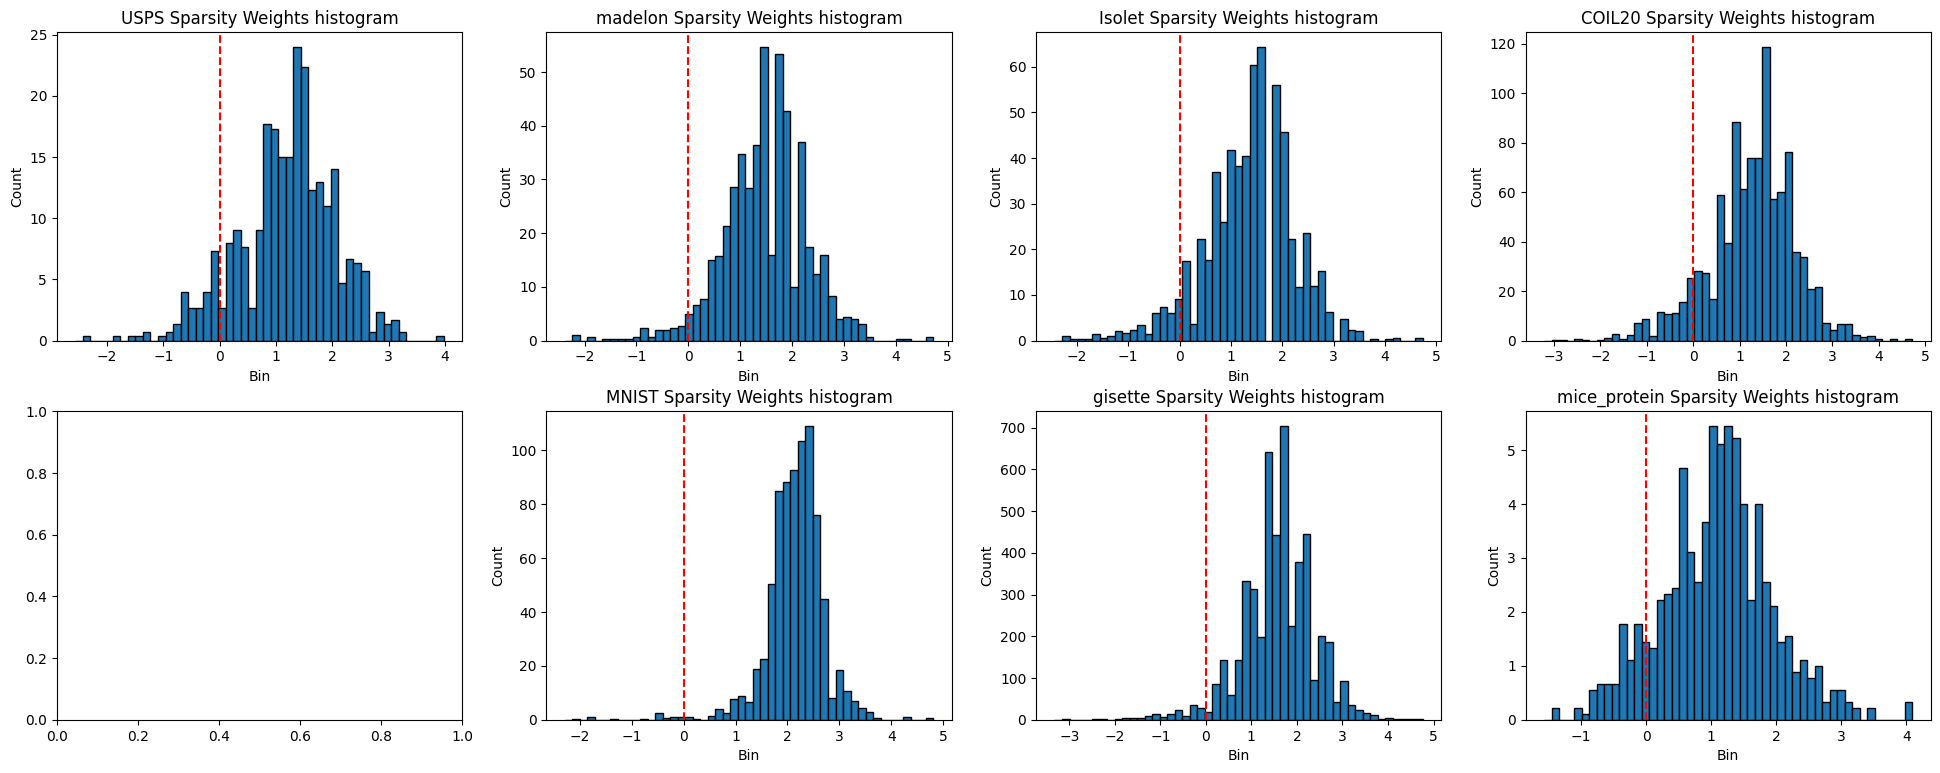

In [53]:
# Determine the layout of the subplots
# Adjust these values based on your specific number of datasets
nrows = int(len(hist_dict)**0.5)  # Square root of the number of datasets for rows
ncols = int(len(hist_dict) / nrows) + (len(hist_dict) % nrows > 0)  # Adjust columns accordingly

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))  # Adjust figsize for landscape layout
fig.tight_layout(pad=3.0)  # Add some padding between plots

for ax, (dataset, histograms) in zip(axs.flatten(), hist_dict.items()):
    try:
        bins, values = combine_histograms(histograms)
    except Exception as e:
        print(f"Error combining histograms for {dataset}: {e}")
        continue
    values /= len(histograms)
    
    # Calculate bin widths and bin centers
    bin_widths = [j - i for i, j in zip(bins[:-1], bins[1:])]
    bin_centers = [(i + j) / 2 for i, j in zip(bins[:-1], bins[1:])]

    # Plotting on the specific subplot axis
    ax.bar(bin_centers, values, width=bin_widths, align='center', edgecolor='black')
    ax.set_xlabel('Bin')
    ax.set_ylabel('Count')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'{dataset} Sparsity Weights histogram')

# Adjust if the number of datasets is not a perfect square to hide empty subplots
for ax in axs.flatten()[len(hist_dict):]:
    ax.set_visible(False)

plt.show()


In [6]:
hist = run.summary['best_mask_parameters']

In [15]:
a = np.array(hist['values'])
b = a
np.vstack((a,b)).mean(axis=0).shape

(32,)

In [16]:
hist

{'values': [1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 3, 4, 3, 10, 18, 15, 37, 32, 40, 50, 59, 59, 44, 30, 32, 21, 11, 14, 2, 4, 5, 2], 'bins': [-2.3778932094573975, -2.191999673843384, -2.006105899810791, -1.8202123641967773, -1.6343187093734741, -1.448425054550171, -1.2625313997268677, -1.0766377449035645, -0.890744149684906, -0.7048504948616028, -0.5189568996429443, -0.3330632448196411, -0.14716961979866028, 0.038724012672901154, 0.22461764514446259, 0.4105112850666046, 0.5964049100875854, 0.7822985649108887, 0.9681921601295471, 1.1540857553482056, 1.3399794101715088, 1.525873064994812, 1.7117667198181152, 1.8976603746414185, 2.0835540294647217, 2.2694475650787354, 2.455341339111328, 2.641234874725342, 2.8271284103393555, 3.0130221843719482, 3.198915719985962, 3.3848094940185547, 3.5707030296325684], '_type': 'histogram'}

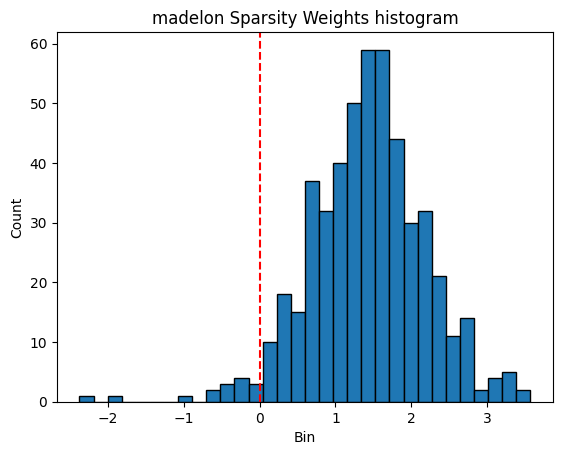

In [9]:

# Histogram data
values = hist['values']
bins = hist['bins']

# Calculate bin widths and bin centers
bin_widths = [j - i for i, j in zip(bins[:-1], bins[1:])]
bin_centers = [(i + j) / 2 for i, j in zip(bins[:-1], bins[1:])]

# Plotting
plt.bar(bin_centers, values, width=bin_widths, align='center', edgecolor='black')
plt.xlabel('Bin')
plt.ylabel('Count')
plt.axvline(x=0, color='red', linestyle='--')

plt.title(f'{dataset} Sparsity Weights histogram')
plt.show()


In [ ]:
# Initialize a list to store data
data = []

# Iterate over each run and fetch the required data
for run in sweep.runs:
    config = run.config
    summary_metrics = run.summary
    # You might need to adjust the key names based on your actual data
    try:
        data.append({
            'dataset': config['dataset'],  
            'seed_model_init': config['seed_model_init'], 
            # Add other hyperparameters here as needed
            'normalize_reconstruction': config['normalize_reconstruction'],  
            'balanced_accuracy': summary_metrics['bestmodel_valid/balanced_accuracy'],  # Adjust based on your summary metrics
            # Include other config elements as necessary
        })
    except:
        print(f"Run {run.id} failed")

# Convert the list to a DataFrame
df = pd.DataFrame(data)

df = df[df['dataset'] != 'poly_binarised_decimalised_mod10_synth'] # excliude this dataset

# Group by dataset and other relevant hyperparameters (excluding seed), and calculate the mean of balanced_accuracy across seeds
grouped_df = df.groupby(['dataset', 
                         'normalize_reconstruction'  # Add other hyperparameters here, except 'seed'
                        ]).agg({'balanced_accuracy': 'mean'}).reset_index()

# Now, find the entry with the maximum 'balanced_accuracy' for each 'dataset'
result_df = grouped_df.loc[grouped_df.groupby('dataset')['balanced_accuracy'].idxmax()]

# Display the resulting DataFrame
print(result_df)


Run x5mlx25b failed
Run 6y520ck9 failed
Run fa1xfouk failed
Run 1691mmmr failed
             dataset normalize_reconstruction  balanced_accuracy
0              MNIST  num_non_masked_features           0.980751
2  simple_trig_synth             num_features           0.979334


In [ ]:
print(grouped_df)

             dataset normalize_reconstruction  balanced_accuracy
0              MNIST  num_non_masked_features           0.980751
1  simple_trig_synth                     None           0.975825
2  simple_trig_synth             num_features           0.979334
3  simple_trig_synth  num_non_masked_features           0.978480
